<h2 style="text-align: center;"><strong>Differential Privacy Strategies for Data Analytics in the Banking Sector</strong></h2>

<div style="text-align: center;">
  Universidad de los Andes<br>
  Author: Daniela Espinosa 202022615<br>
</div>


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pure_ldp.frequency_oracles.direct_encoding import DEClient

### Cargar datos

In [12]:
# Cargar el dataset
data_path = '../data/raw/bank-full.csv'
df = pd.read_csv(data_path, sep=';')

# Mapear la variable objetivo
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Separar características y objetivo
X = df.drop(columns=['y'])
y = df['y']

# Mejores parámetros encontrados
best_params_rf = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Definición de funciones

In [ ]:
# Función para mapear variables categóricas binarias y meses
def map_binary_columns(df):
    """
    Convierte las columnas binarias de 'no'/'yes' a 0/1.
    También convierte los meses a valores numéricos.
    """
    df['default'] = df['default'].map({'no': 0, 'yes': 1})
    df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
    df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
    df['month'] = df['month'].map({
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    })
    return df

# Función para mapear variables categóricas con 3+ categorías
def map_categorical_columns(df, categorical_columns):
    """
    Convierte las columnas categóricas con más de dos categorías a valores numéricos.
    Genera un mapeo para cada columna.
    """
    mappings = {}
    for col in categorical_columns:
        unique_values = df[col].unique()
        mappings[col] = {value: idx for idx, value in enumerate(unique_values)}
        df[col] = df[col].map(mappings[col])
    return df, mappings

# Función para aplicar de con Direct Encoding
def apply_de(df, epsilon, categorical_columns):
    """
    Aplica Local Differential Privacy (LDP) usando el método Direct Encoding (DE).
    Cada valor categórico se privatiza añadiendo ruido controlado por el parámetro epsilon.
    """
    df_de = df.copy()
    for col in categorical_columns:
        de = DEClient(epsilon=epsilon, d=df[col].nunique())
        df_de[col] = df[col].apply(lambda x: de.privatise(x))
    return df_de

# Procesamiento completo: incluye OHE antes y después de DE
def process_data(X, y, categorical_columns, apply_DE=False, epsilon=None):
    """
    Procesa los datos:
    - Aplica Direct Encoding si está activado
    - One-Hot Encoding (OHE)
    - Split train-test
    - Escalado de columnas numéricas
    - Oversampling con SMOTEENN
    - Selección de características con Boruta
    """
    x = X.copy()
    if apply_DE and epsilon:
        x = apply_de(x, epsilon, categorical_columns)

    # One-Hot Encoding (OHE)
    x = pd.get_dummies(x, columns=categorical_columns, drop_first=True, dtype='int64')

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Escalado de las columnas numéricas
    numeric_columns = ['age', 'balance', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous']
    scaler = MinMaxScaler()
    X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
    X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

    # Aplicar SMOTEENN para balancear clases
    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

    # Selección de características con Boruta
    rf = RandomForestClassifier(**best_params_rf, random_state=42)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=0)
    boruta.fit(X_train_resampled.values, y_train_resampled.values)
    selected_features = X_train_resampled.columns[boruta.support_].tolist()
    return X_train_resampled[selected_features], X_test[selected_features], y_train_resampled, y_test

# Entrenar y evaluar modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    """
    Entrena un RandomForestClassifier y calcula varias métricas de evaluación.
    Incluye métricas como AUC, Accuracy, Precision, Recall, F1, y errores tipo I y II.
    """
    model = RandomForestClassifier(**best_params_rf, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_pct = conf_matrix[0][1] / actual_negatives
    false_negative_pct = conf_matrix[1][0] / actual_positives
    
    # Métricas
    return {
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error': false_positive_pct,
        'Type II Error': false_negative_pct
    }


In [ ]:
# Variables categóricas con 3+ categorías (para One-Hot Encoding)
categorical_columns_3 = ['job', 'marital', 'education', 'contact', 'poutcome']

# Todas las variables categóricas (para Direct Encoding)
all_categorical_columns = ['default', 'housing', 'loan', 'job', 'marital', 'education', 'contact', 'poutcome']

# Epsilons y resultados
epsilons = [5, 1, 0.1]
results = {}

### Mapeo de columnas categóricas

In [ ]:
# Preprocesar datos originales
X = map_binary_columns(X)
X, cat_mappings = map_categorical_columns(X, categorical_columns_3)

### Modelo sin privacidad

In [ ]:
# Modelo sin Direct Encoding
X_train, X_test, y_train, y_test = process_data(X, y, categorical_columns_3)
results['Original'] = evaluate_model(X_train, y_train, X_test, y_test)

### Modelos con privacidad

In [16]:
# Modelos con Direct Encoding
for epsilon in epsilons:
    X_train_de, X_test_de, y_train_de, y_test_de = process_data(X, y, categorical_columns_3, apply_DE=True, epsilon=epsilon)
    results[f'DE (ε ={epsilon})'] = evaluate_model(X_train_de, y_train_de, X_test_de, y_test_de)

# Resultados
results_df = pd.DataFrame(results)
results_df

,Original,DE (ε =5),DE (ε =1),DE (ε =0.1)
ROC AUC,0.926362,0.924490,0.916603,0.914991
Accuracy,0.877175,0.876733,0.881893,0.879092
Precision,0.486791,0.485410,0.499124,0.490781
Recall,0.784105,0.770338,0.712766,0.699625
F1 Score,0.600671,0.595549,0.587113,0.576883
Type I Error,0.110396,0.109059,0.095521,0.096941
Type II Error,0.215895,0.229662,0.287234,0.300375


### Gráficas

<Figure size 1200x600 with 0 Axes>

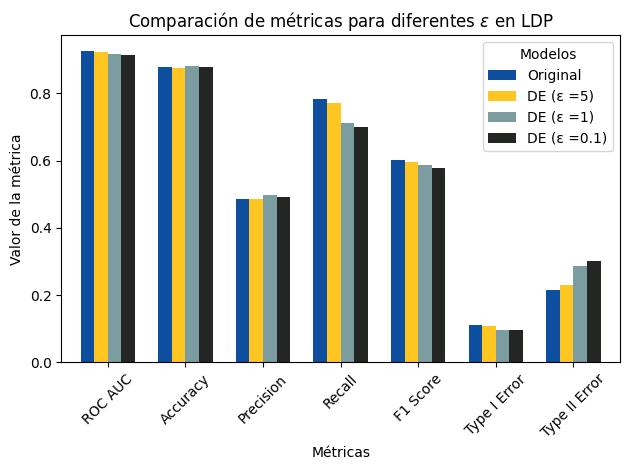

In [ ]:
# Definir colores personalizados
colores = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624']

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
ax = results_df.plot(kind='bar', width=0.7, color=colores)

# Añadir título y etiquetas
plt.title('Comparación de métricas para diferentes $\epsilon$ en LDP')
plt.xlabel('Métricas')
plt.ylabel('Valor de la métrica')
plt.xticks(rotation=45)
plt.legend(title='Modelos')

# Ajustar diseño
plt.tight_layout()
plt.show()